CRYPTO FLOW ANALYSIS: Volume-Based Regime Detection

Symbols: BTCUSD, ETHUSD, SOLUSD, XRPUSD
Timeframes: 1H, 4H, 1D
Initialized Crypto Flow Analyzer for 4 symbols

Loading data for 4 symbols...

Processing BTCUSD:
  2016: 104,959 valid observations
  2017: 104,783 valid observations
  2018: 104,799 valid observations
  2019: 105,015 valid observations
  2020: 105,300 valid observations
  2021: 105,109 valid observations
  2022: 105,119 valid observations
  2023: 105,057 valid observations
  2024: 105,384 valid observations
  2025: 65,849 valid observations
  Total observations: 1,011,374

Processing ETHUSD:
  2016: 53,297 valid observations
  2017: 103,702 valid observations
  2018: 105,009 valid observations
  2019: 105,067 valid observations
  2020: 105,301 valid observations
  2021: 105,109 valid observations
  2022: 105,119 valid observations
  2023: 105,057 valid observations
  2024: 105,383 valid observations
  2025: 65,843 valid observations
  Total observations: 958,887

Proces

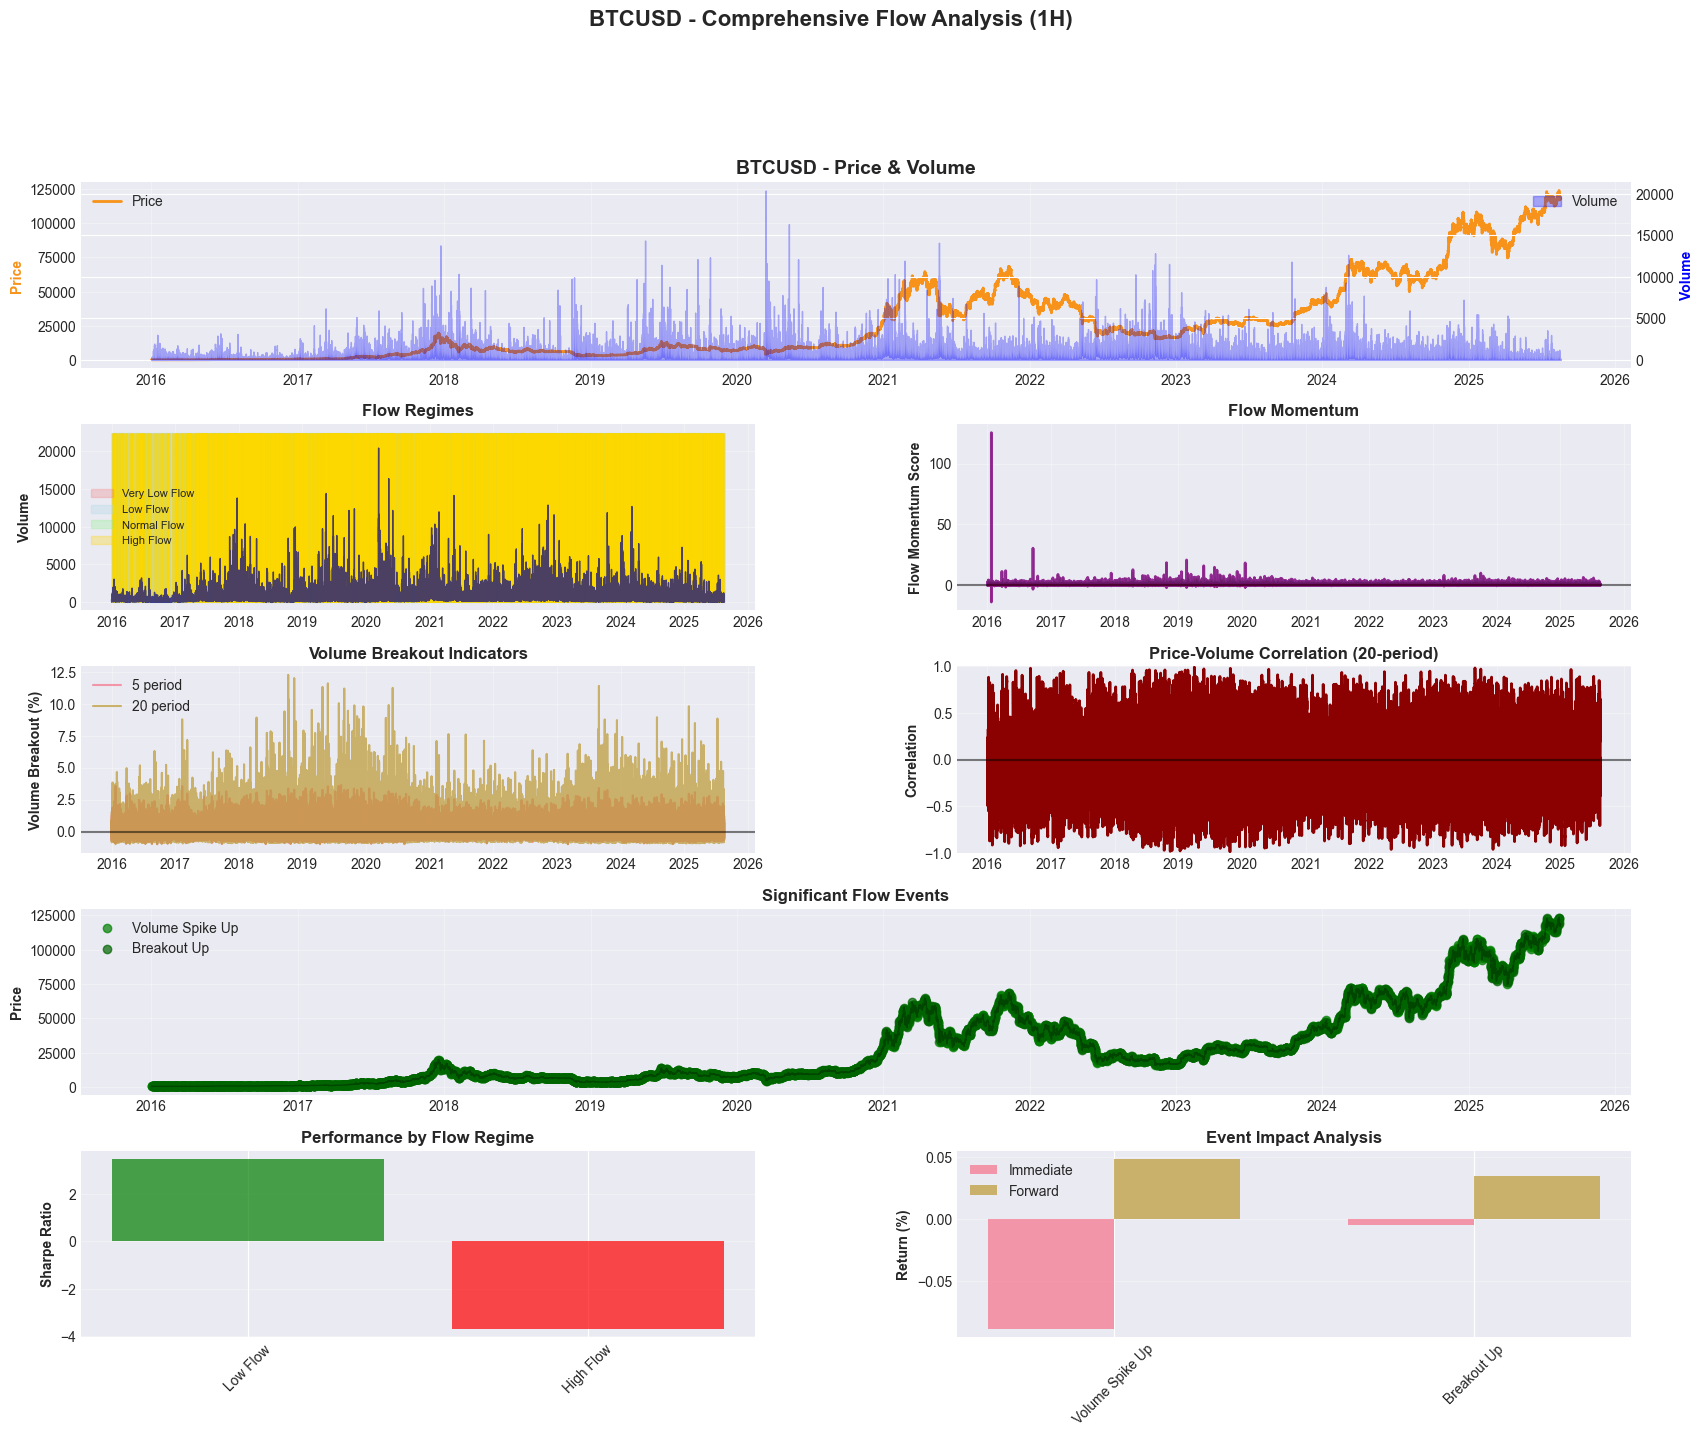

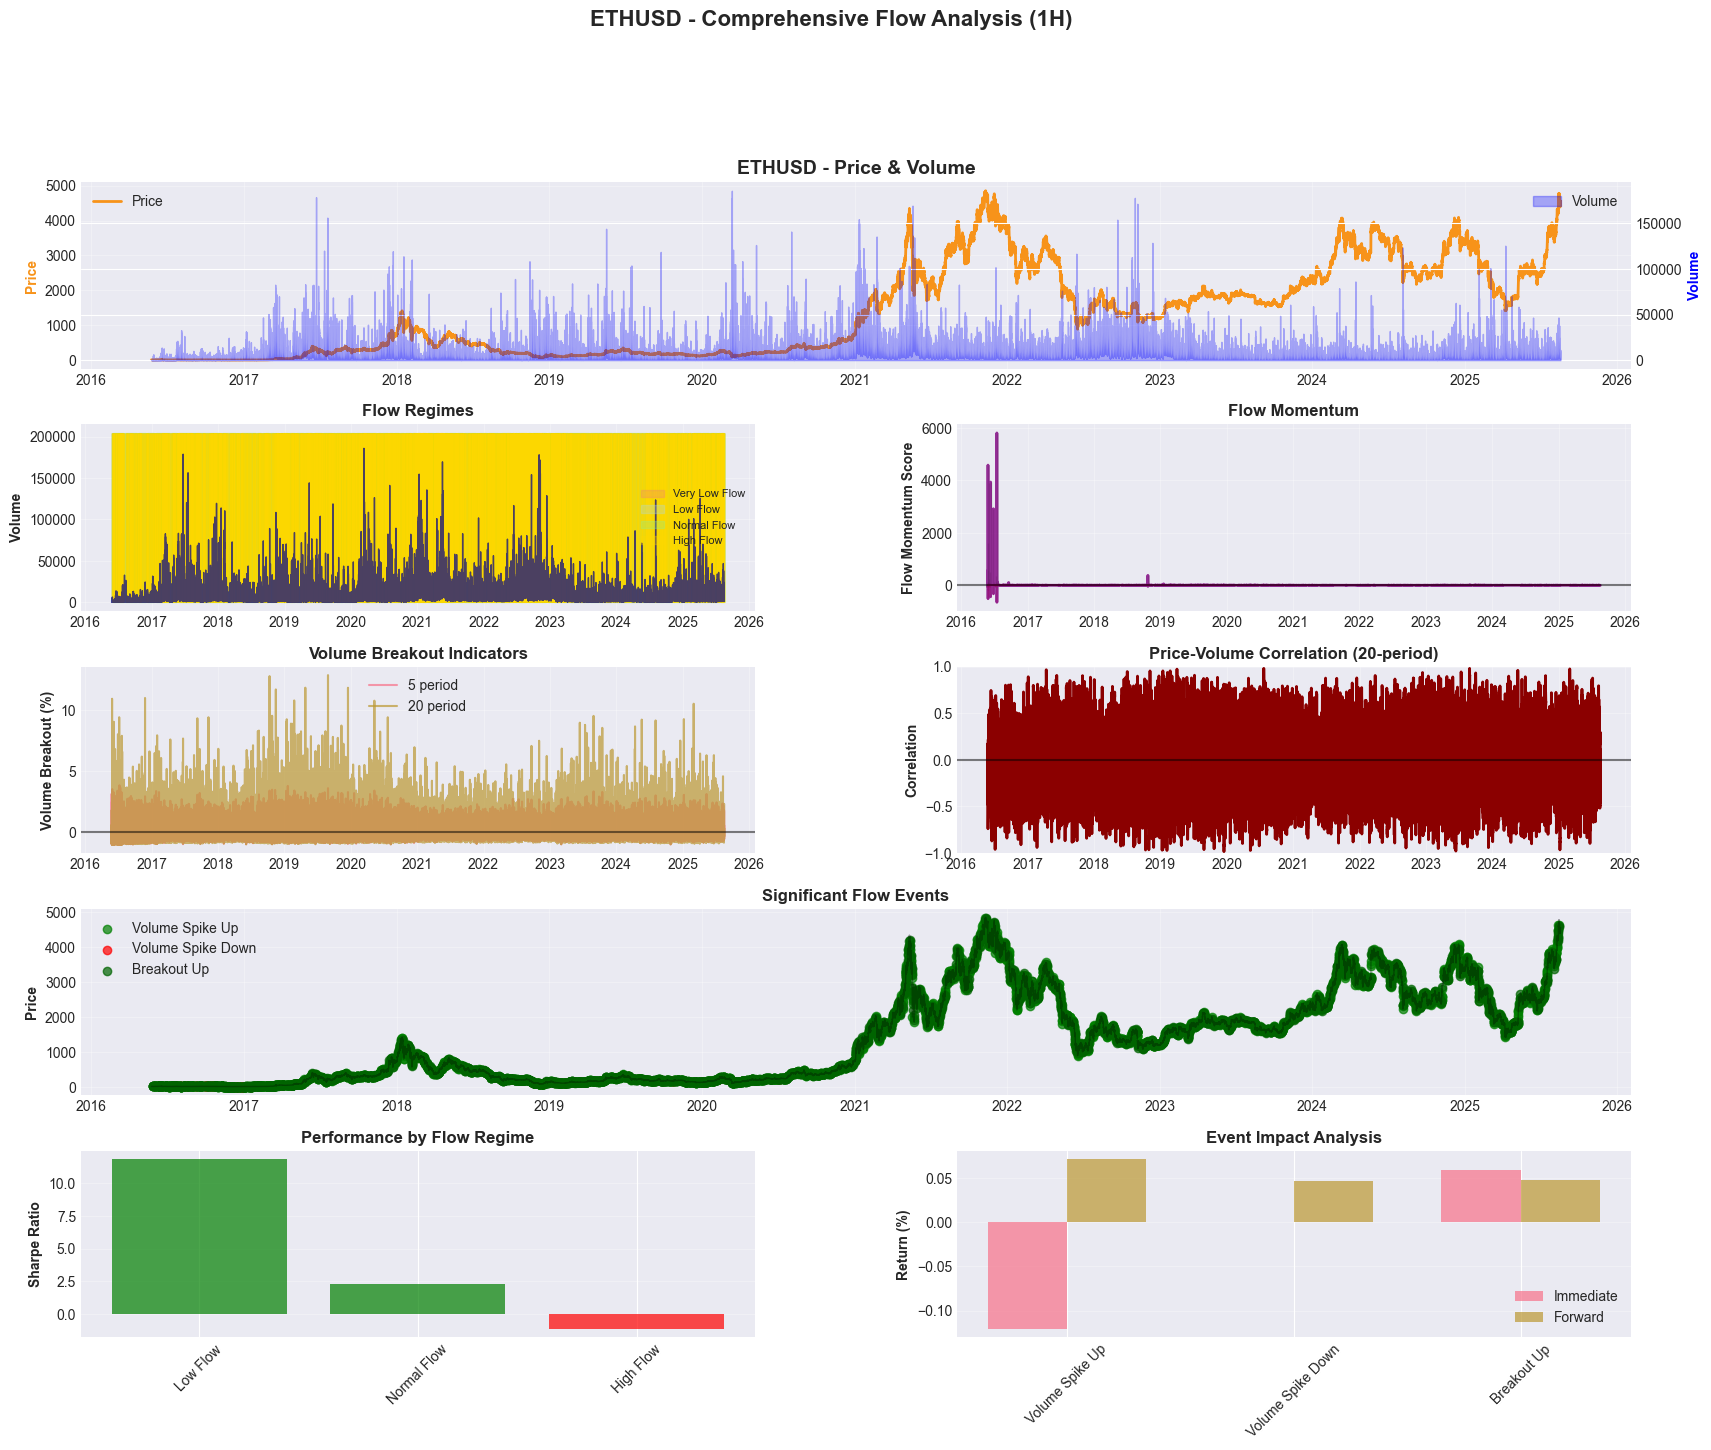

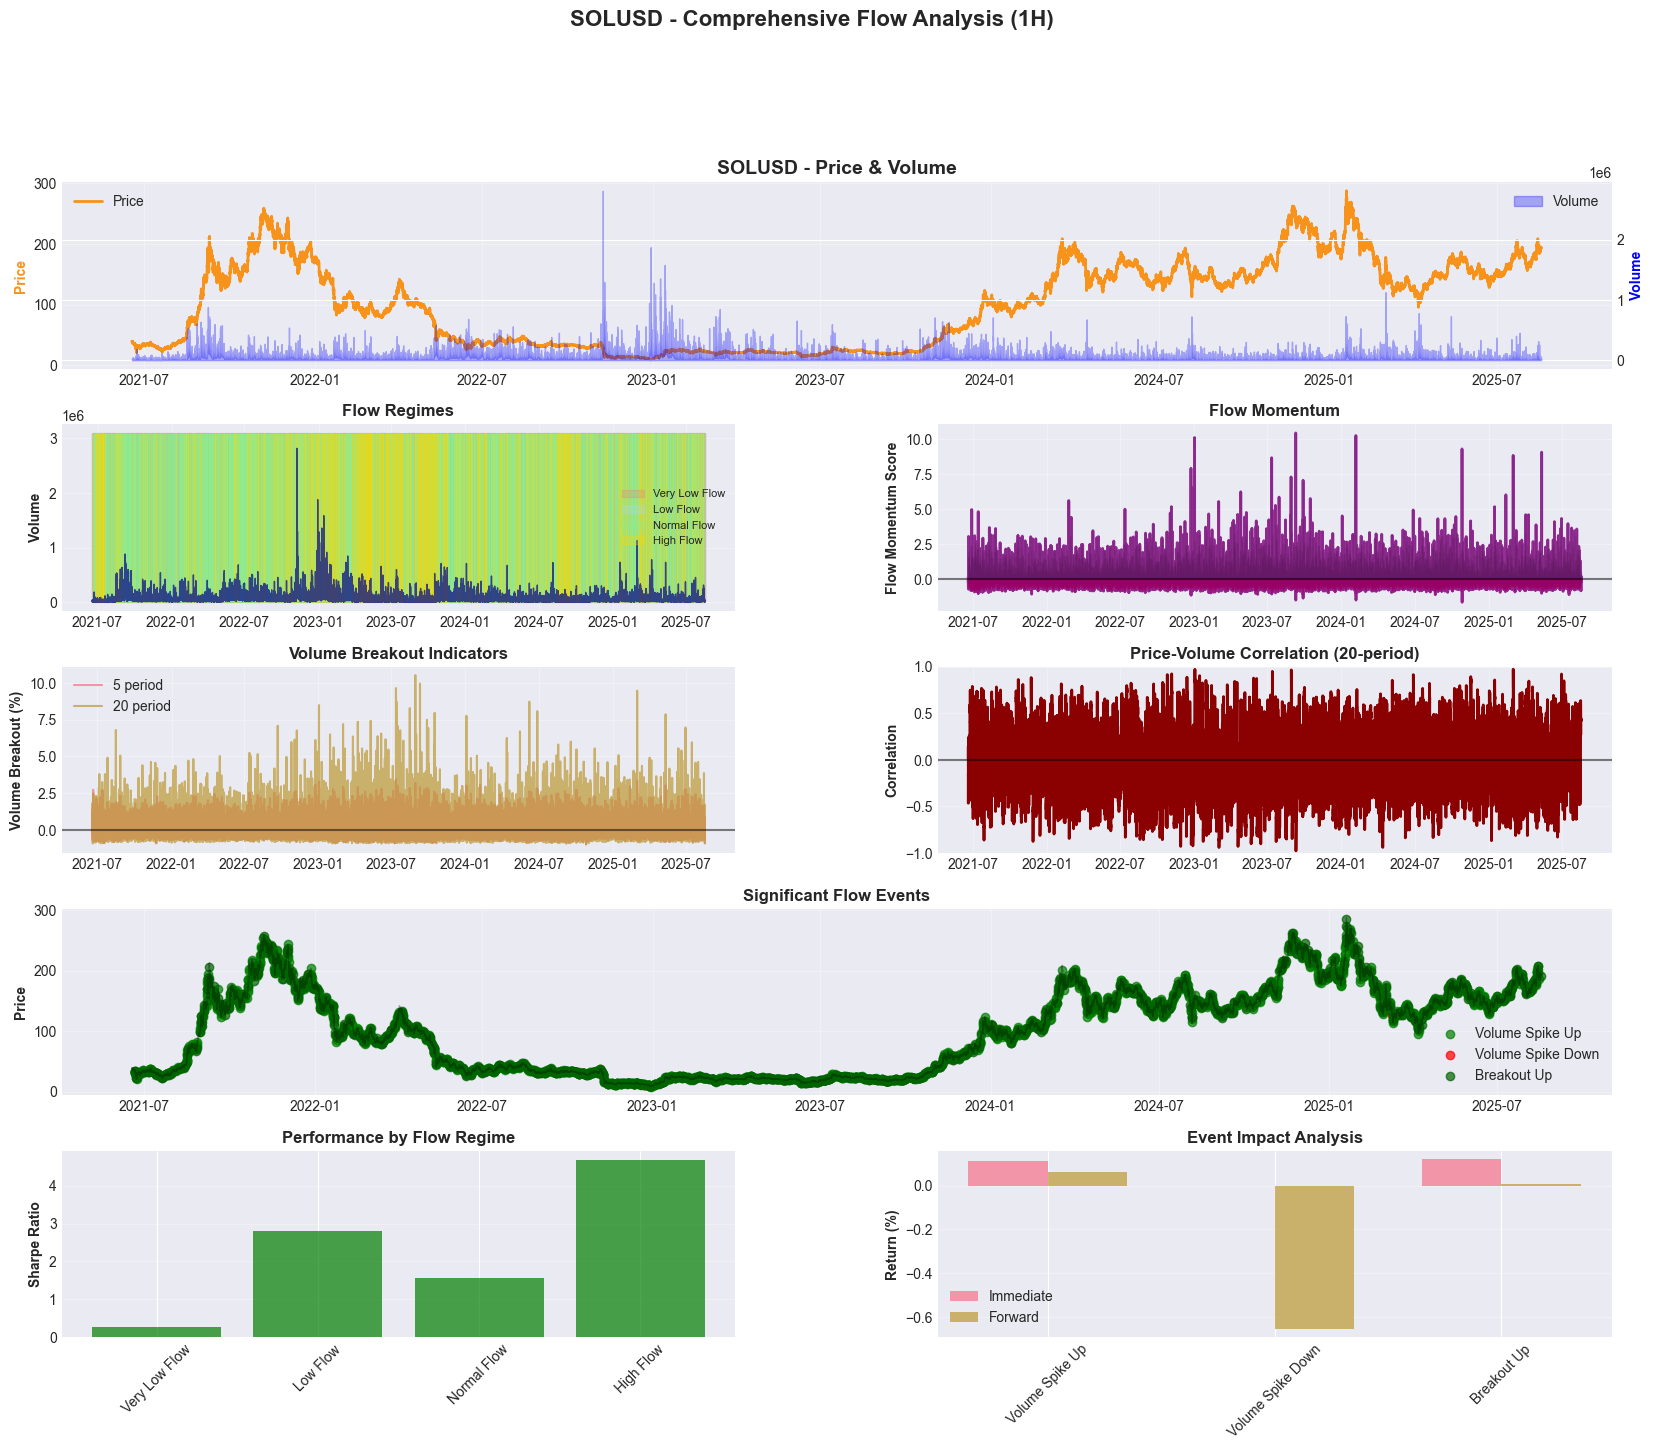

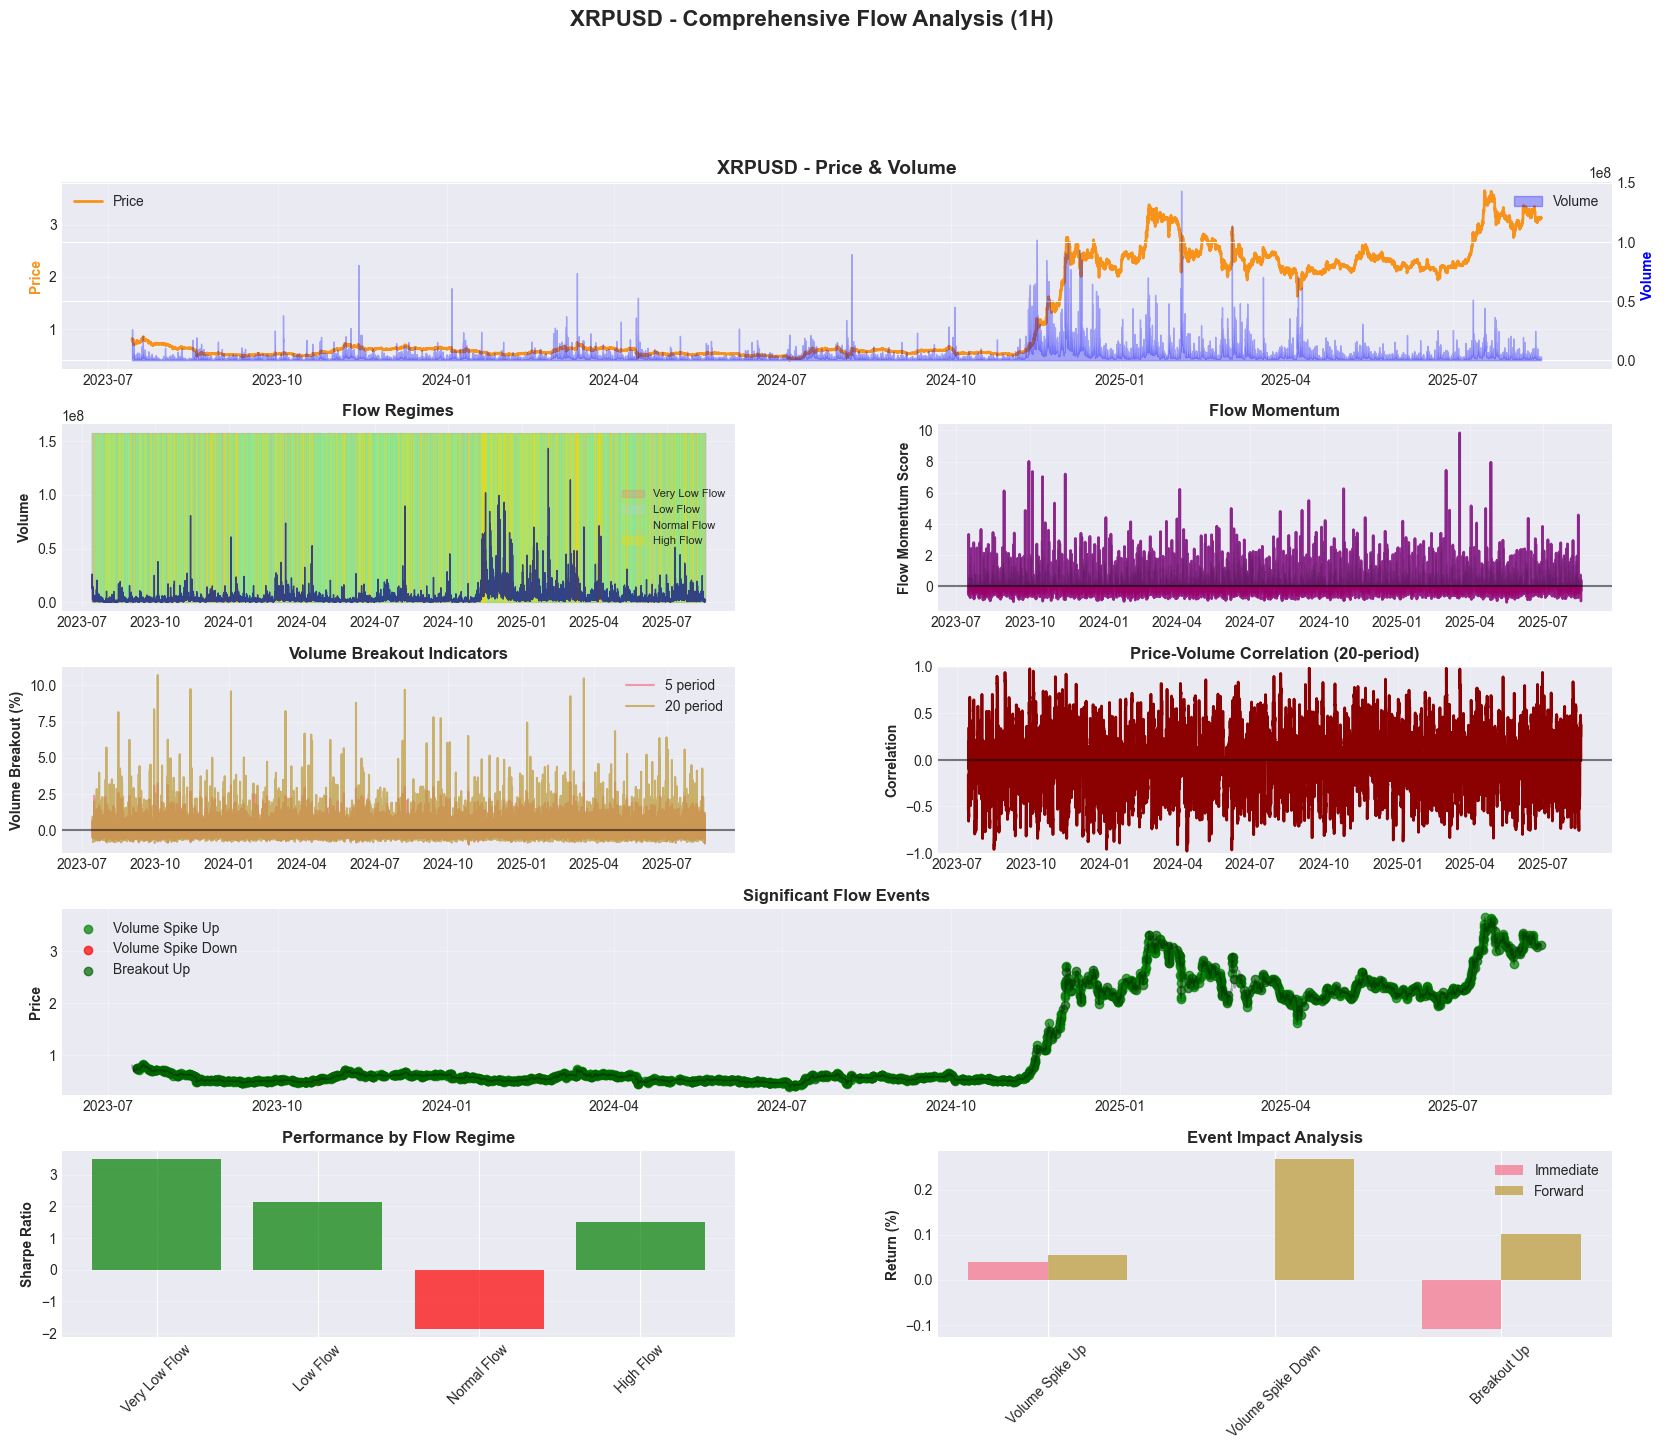

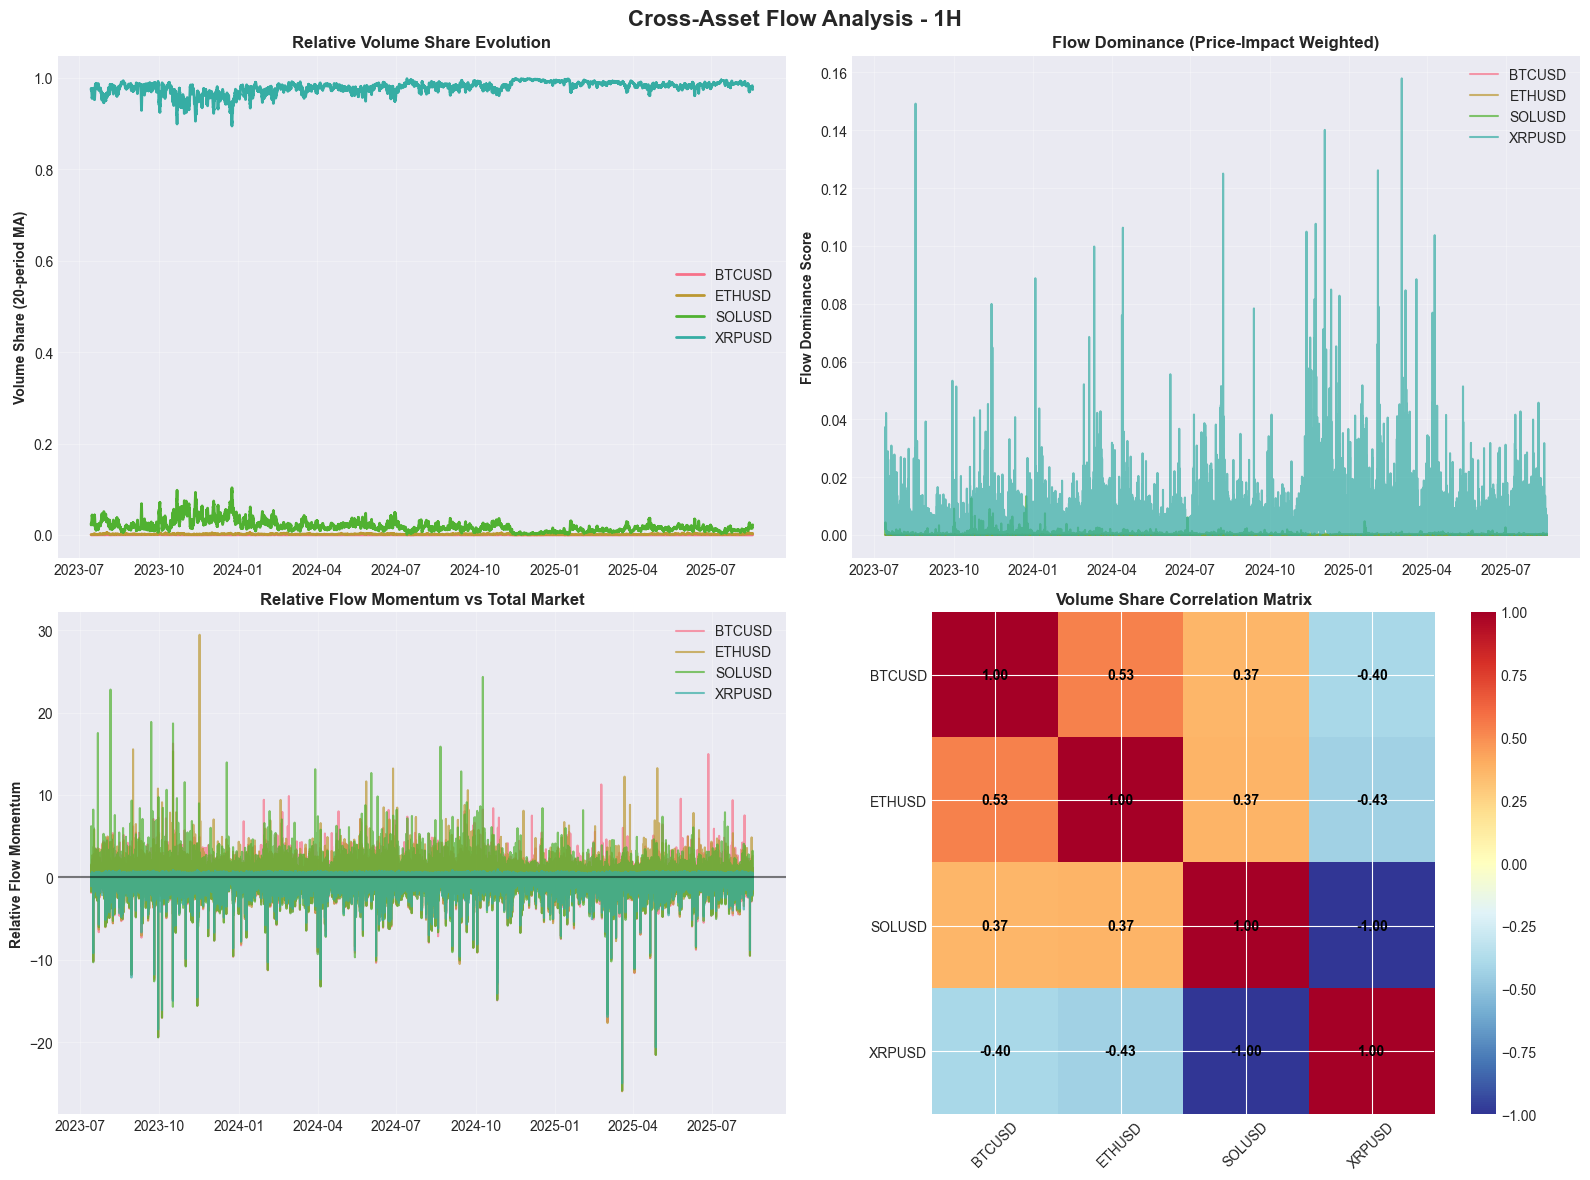


COMPREHENSIVE FLOW ANALYSIS - 4H

Analyzing BTCUSD...
  Flow regimes: 4 regimes detected
    Very Low Flow  : Sharpe=  6.55, Return= 0.066%, PosRatio= 53.1%
    Low Flow       : Sharpe=  0.95, Return= 0.012%, PosRatio= 48.8%
    Normal Flow    : Sharpe= -0.40, Return=-0.010%, PosRatio= 49.8%
    High Flow      : Sharpe= -7.27, Return=-0.296%, PosRatio= 47.1%
Analyzing ETHUSD...
  Flow regimes: 3 regimes detected
    Low Flow       : Sharpe=-32.36, Return=-0.763%, PosRatio= 41.5%
    Normal Flow    : Sharpe=  4.52, Return= 0.068%, PosRatio= 51.3%
    High Flow      : Sharpe= -0.93, Return=-0.038%, PosRatio= 48.8%
Analyzing SOLUSD...
  Flow regimes: 4 regimes detected
    Very Low Flow  : Sharpe=  1.31, Return= 0.023%, PosRatio= 49.9%
    Low Flow       : Sharpe=  3.42, Return= 0.061%, PosRatio= 50.9%
    Normal Flow    : Sharpe=  2.61, Return= 0.098%, PosRatio= 50.7%
    High Flow      : Sharpe=  2.36, Return= 0.100%, PosRatio= 48.0%
Analyzing XRPUSD...
  Flow regimes: 4 regimes detect

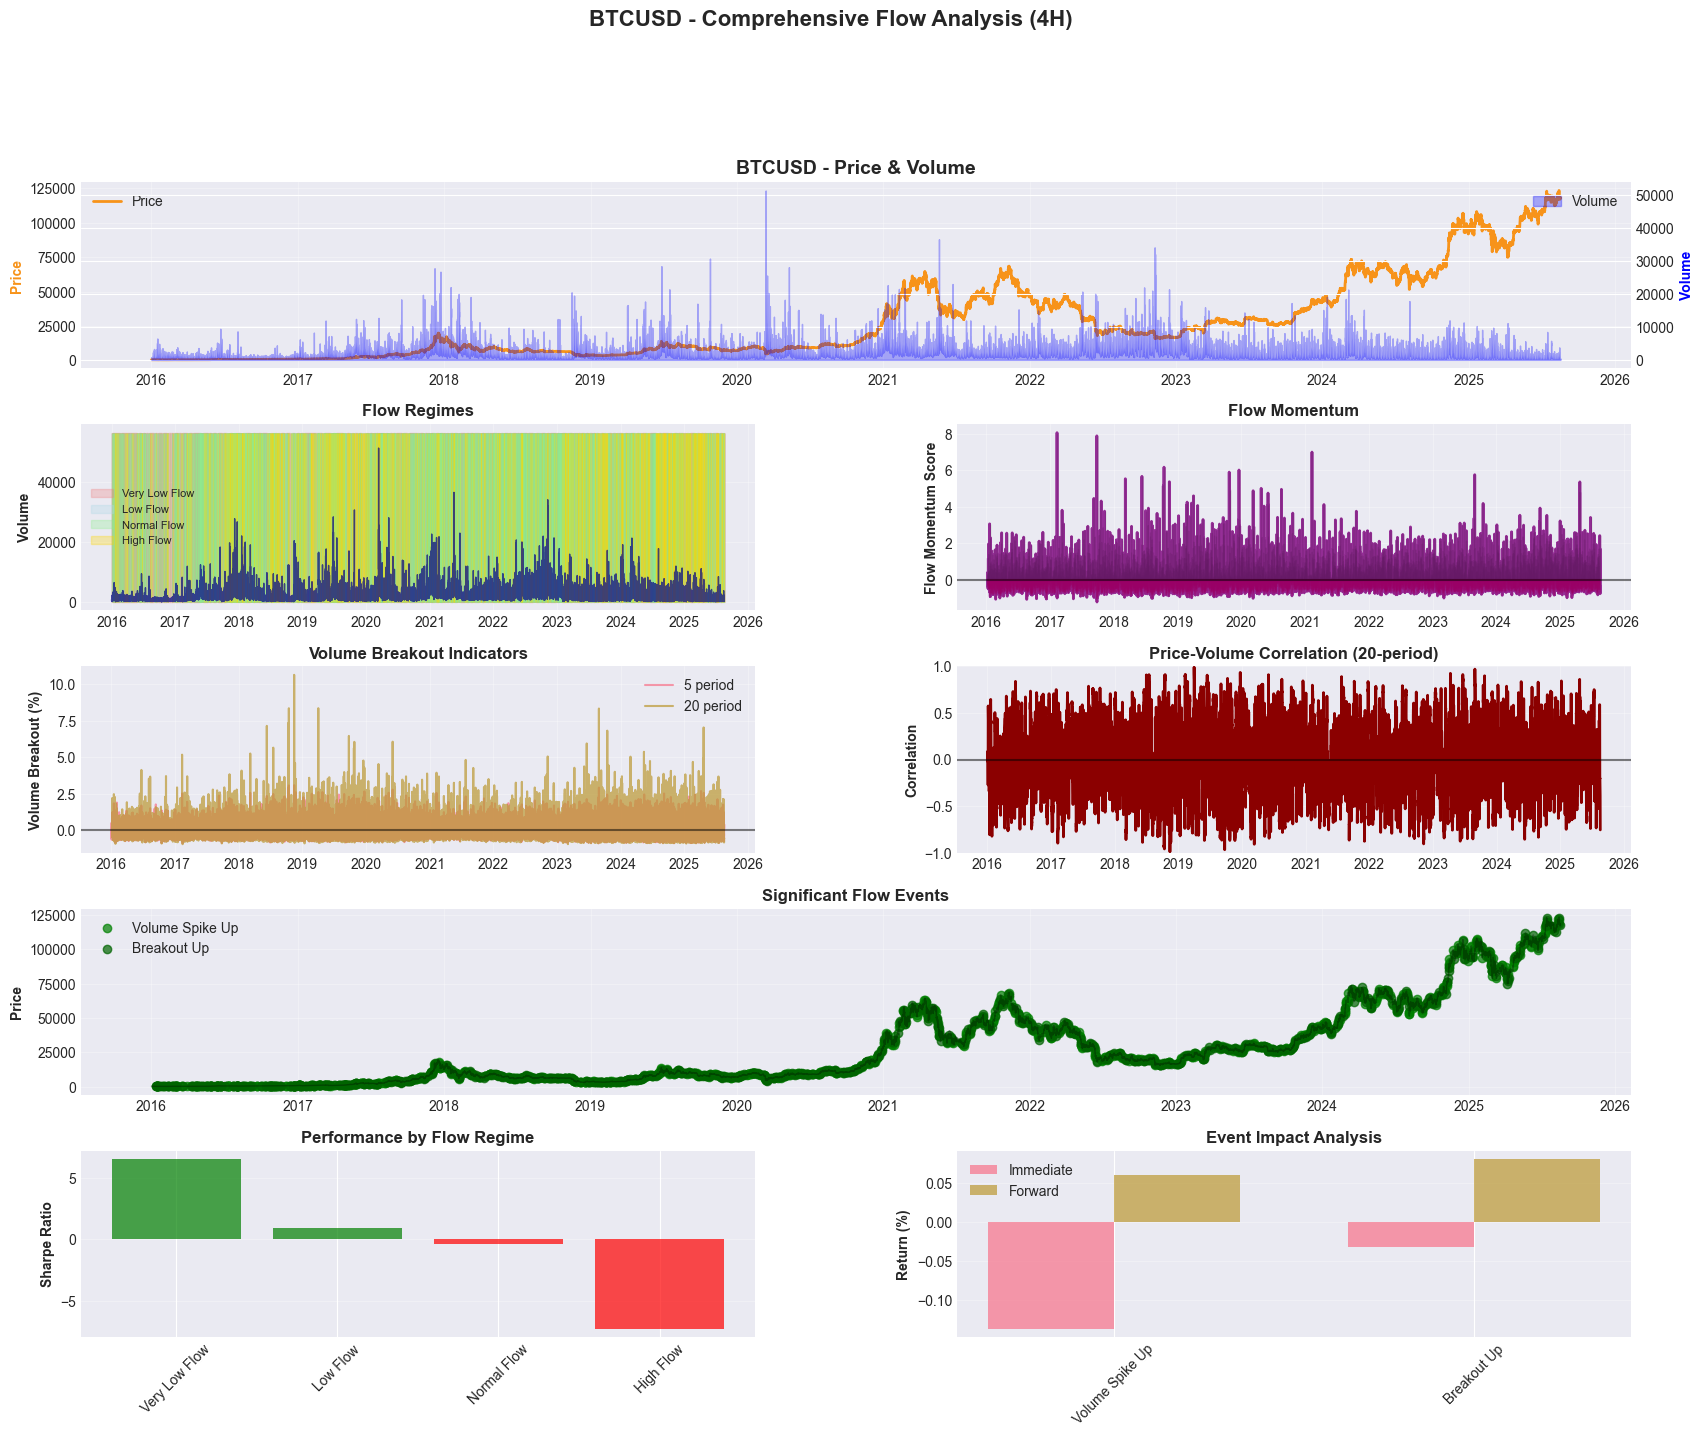

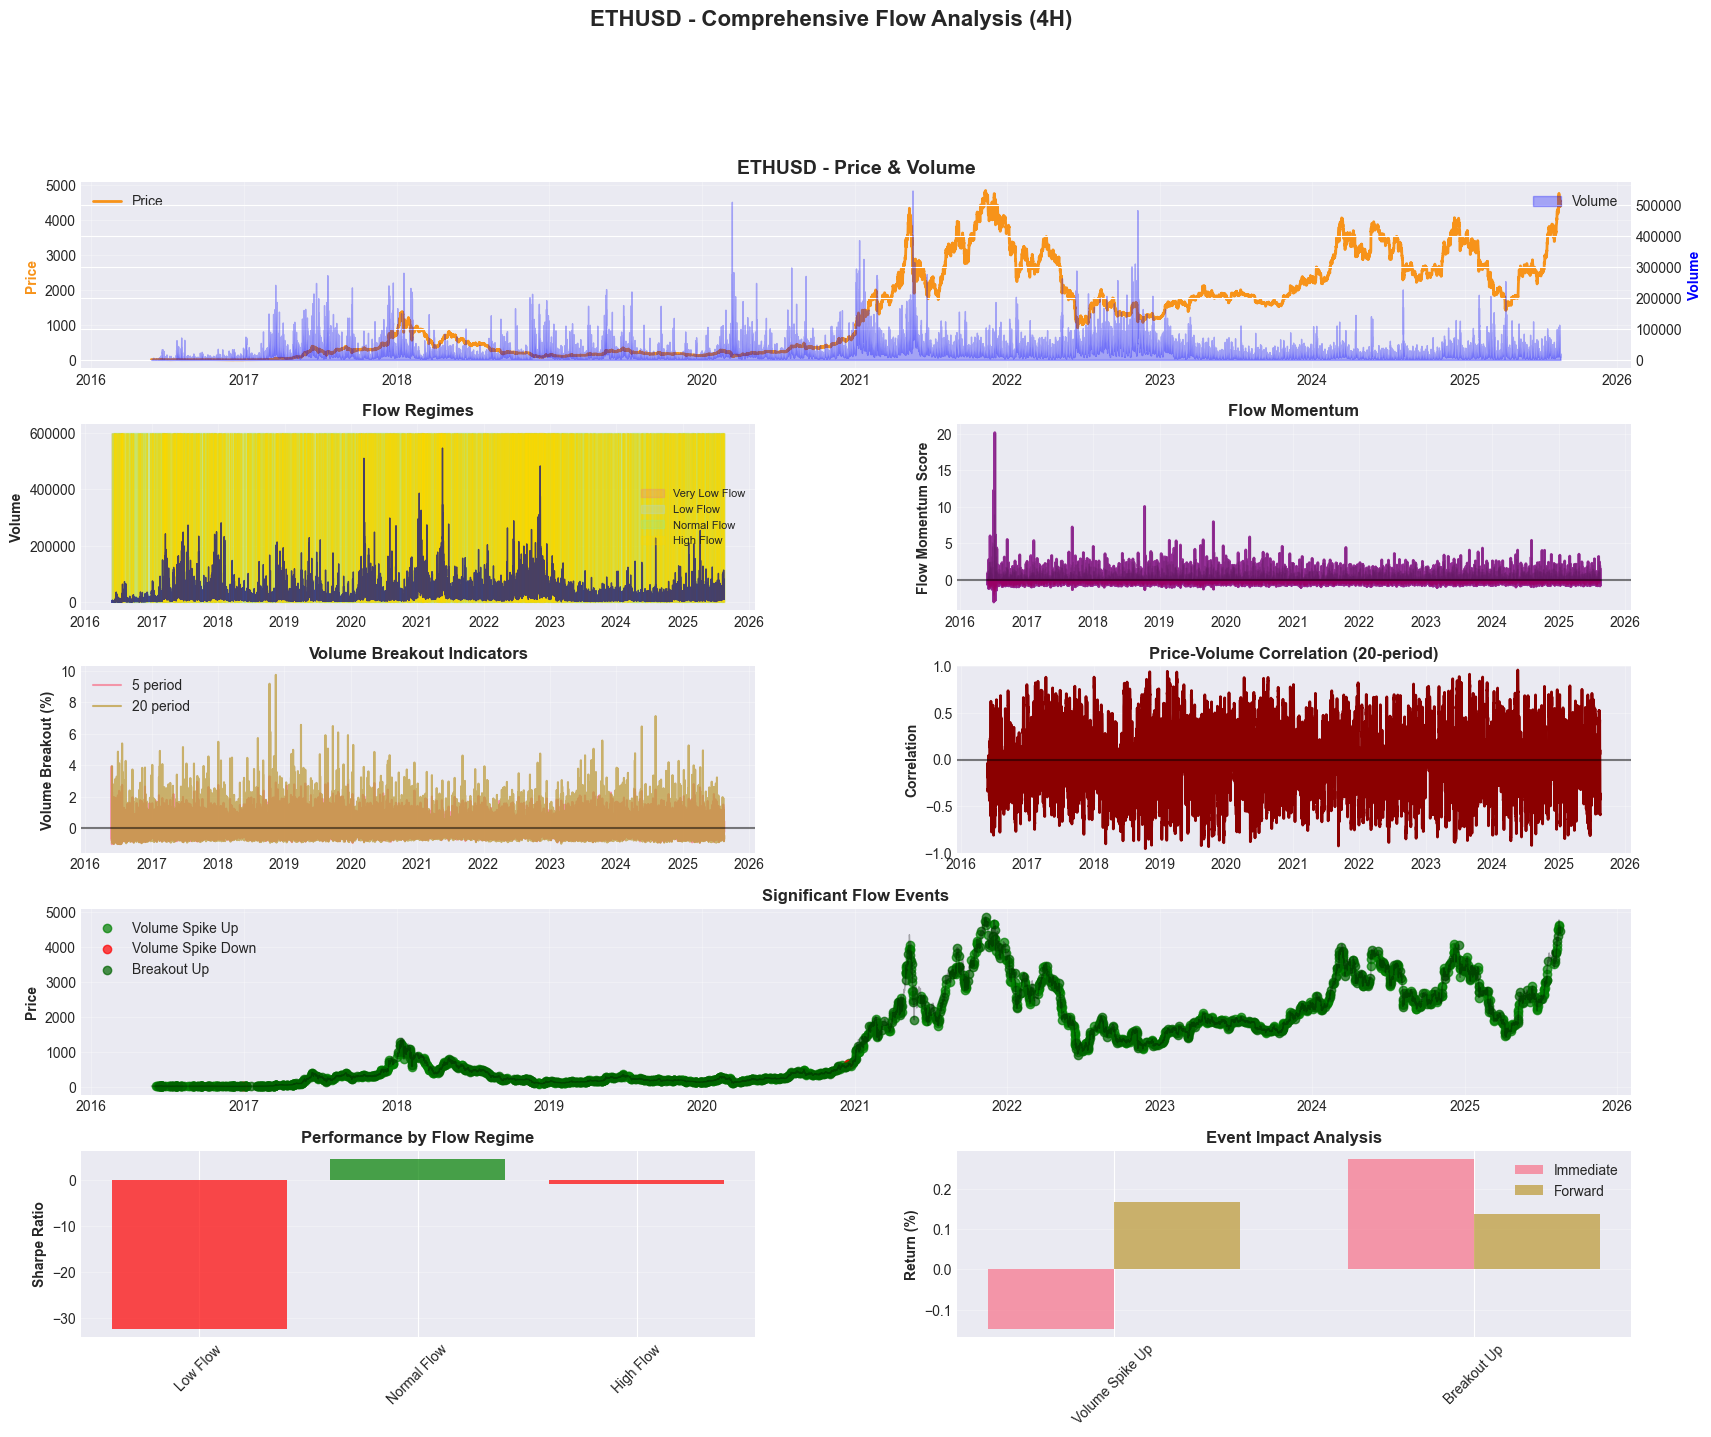

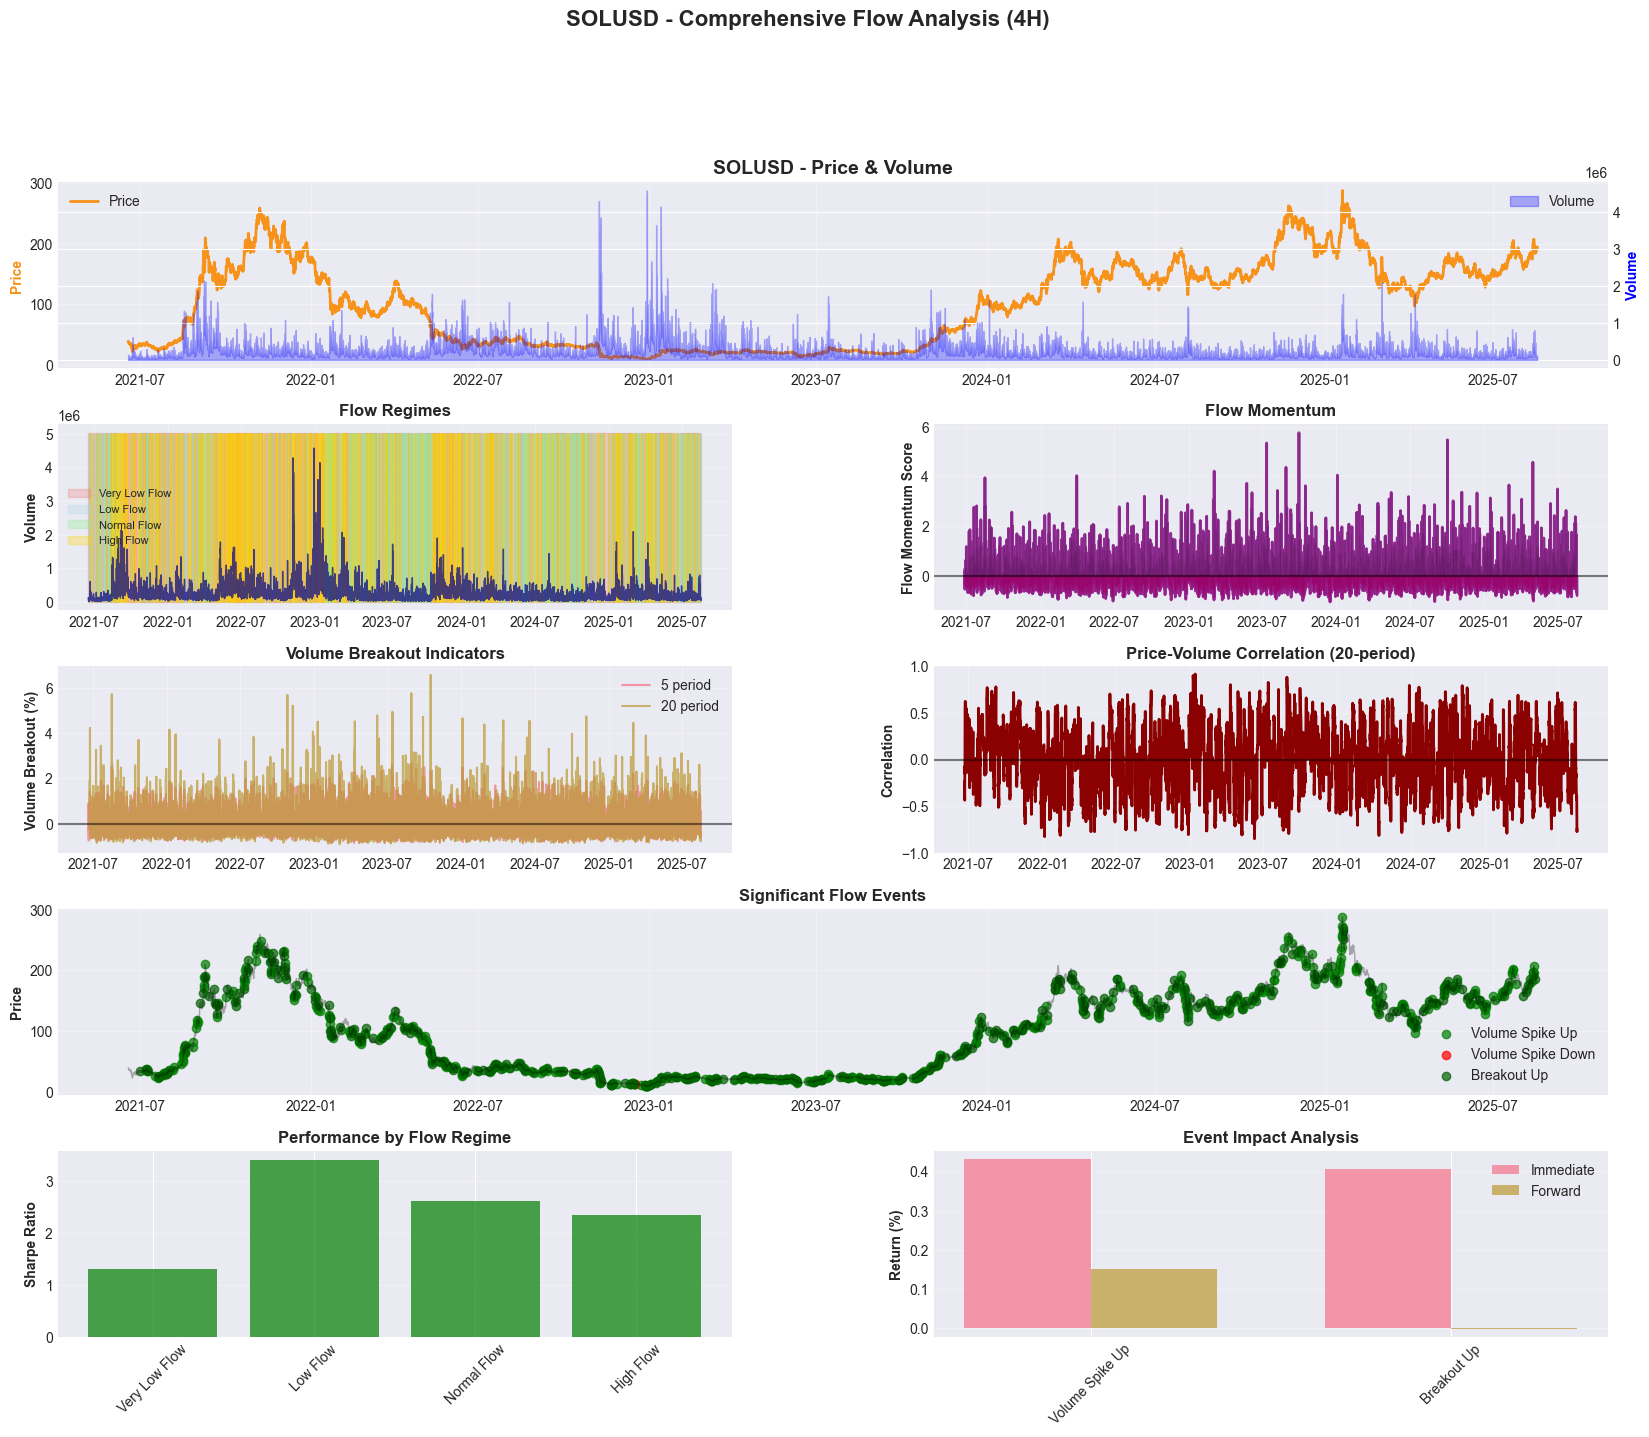

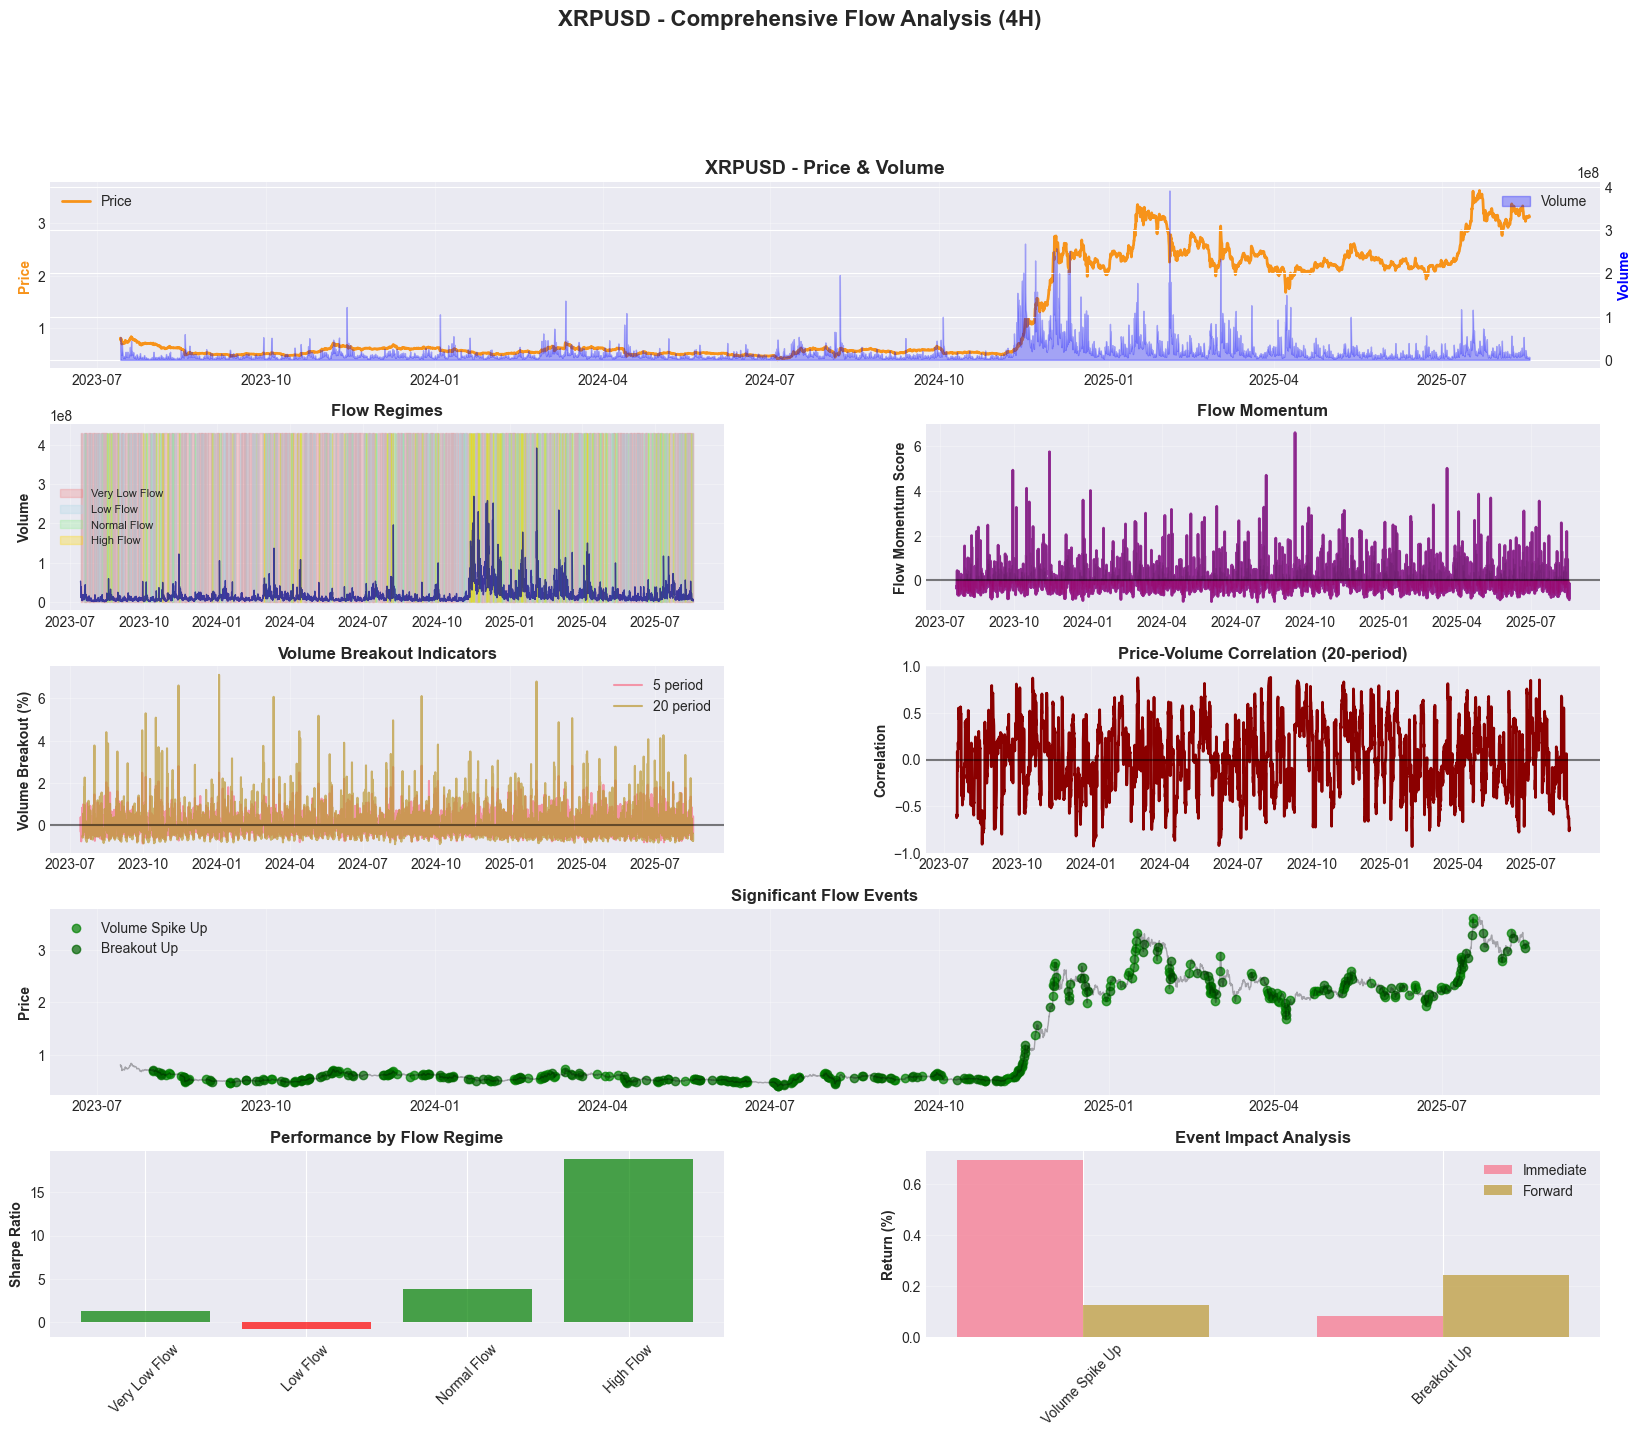

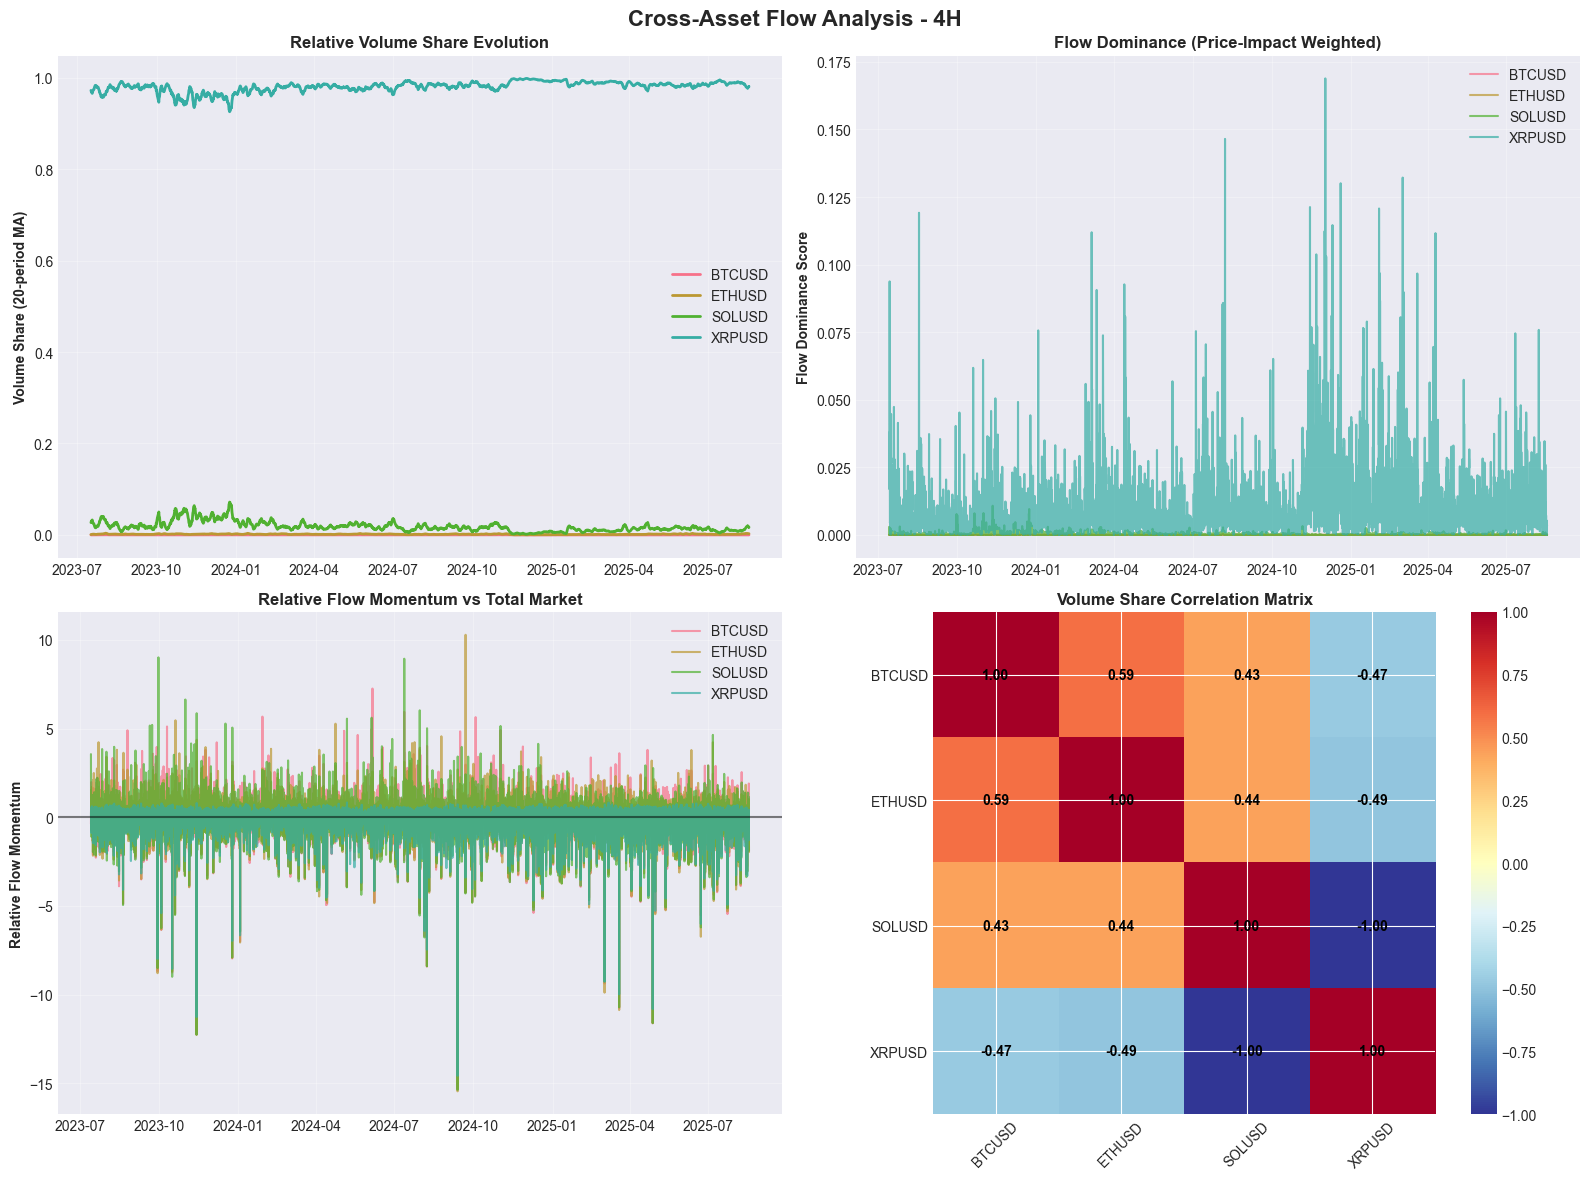


ANALYSIS COMPLETE



In [2]:
"""
Crypto Flow Analysis: Volume-Based Regime Detection and Flow Momentum
Focuses on capturing idiosyncratic crypto flows through volume analysis
"""

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class CryptoFlowAnalyzer:
    """
    Analyzes cryptocurrency flows through volume-based regime detection
    and flow momentum indicators.
    """
    
    def __init__(self, symbols, data_dir="coinbase/5m"):
        self.symbols = symbols
        self.data_dir = Path(data_dir)
        self.data = {}
        self.flow_metrics = {}
        
        print(f"Initialized Crypto Flow Analyzer for {len(symbols)} symbols")
    
    def load_data(self):
        """Load and prepare data for all symbols."""
        print(f"\nLoading data for {len(self.symbols)} symbols...")
        csv_columns = ["timestamp", "open", "high", "low", "close", "volume"]
        
        for symbol in self.symbols:
            print(f"\nProcessing {symbol}:")
            yearly_dfs = []
            
            for year_dir in sorted(self.data_dir.iterdir()):
                if not year_dir.is_dir():
                    continue
                    
                file_path = year_dir / f"{symbol}_5m_{year_dir.name}.csv"
                if file_path.exists():
                    df = pl.read_csv(file_path, has_header=False, new_columns=csv_columns)
                    
                    df_clean = df.filter(
                        pl.col("close").is_not_null() &
                        pl.col("volume").is_not_null() &
                        (pl.col("close") > 0) &
                        (pl.col("volume") >= 0) &
                        pl.col("close").is_finite() &
                        pl.col("volume").is_finite()
                    )
                    
                    yearly_dfs.append(df_clean)
                    print(f"  {year_dir.name}: {df_clean.height:,} valid observations")
            
            if not yearly_dfs:
                print(f"  Warning: No data found for {symbol}")
                continue
            
            combined_df = pl.concat(yearly_dfs)
            combined_df = combined_df.with_columns(
                (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("datetime")
            ).sort("datetime")
            
            combined_df = combined_df.unique(subset=["datetime"], keep="first")
            self.data[symbol] = combined_df
            
            print(f"  Total observations: {combined_df.height:,}")
        
        return self
    
    def create_flow_timeframes(self, timeframes):
        """Create aggregated datasets for flow analysis."""
        print(f"\nCreating multi-timeframe flow datasets...")
        self.timeframe_data = {}
        
        for tf_label, tf_freq in timeframes.items():
            tf_data = {}
            for symbol in self.symbols:
                if symbol not in self.data:
                    continue
                    
                agg_data = self.data[symbol].group_by_dynamic("datetime", every=tf_freq).agg([
                    pl.col("open").first().alias("open"),
                    pl.col("high").max().alias("high"),
                    pl.col("low").min().alias("low"),
                    pl.col("close").last().alias("close"),
                    pl.col("volume").sum().alias("volume")
                ]).filter(pl.col("volume") > 0).sort("datetime")
                
                tf_data[symbol] = agg_data
            
            self.timeframe_data[tf_label] = tf_data
            print(f"  {tf_label:>5s}: {len(tf_data)} symbols loaded")
        
        return self
    
    def calculate_flow_momentum(self, prices, volumes, lookbacks=[5, 10, 20, 50]):
        """Calculate comprehensive flow momentum indicators."""
        # Convert to pandas for easier rolling calculations
        df = pd.DataFrame({'price': prices, 'volume': volumes})
        
        metrics = {}
        
        # Price-volume relationships
        metrics['price_momentum'] = df['price'].pct_change()
        metrics['volume_momentum'] = df['volume'].pct_change()
        
        # Volume-weighted price moves
        metrics['vwap'] = (df['price'] * df['volume']).cumsum() / df['volume'].cumsum()
        metrics['vwap_deviation'] = (df['price'] - metrics['vwap']) / metrics['vwap']
        
        # Flow intensity indicators
        for lookback in lookbacks:
            # Volume acceleration
            metrics[f'volume_accel_{lookback}'] = (
                df['volume'].pct_change() - 
                df['volume'].pct_change().rolling(lookback).mean()
            )
            
            # Volume breakout indicators
            metrics[f'volume_breakout_{lookback}'] = (
                df['volume'] / df['volume'].rolling(lookback).mean() - 1
            )
            
            # Price-volume correlation
            rolling_corr = df['price'].pct_change().rolling(lookback).corr(df['volume'])
            metrics[f'price_volume_corr_{lookback}'] = rolling_corr
        
        # Flow regime detection
        volume_ma_short = df['volume'].rolling(10).mean()
        volume_ma_long = df['volume'].rolling(50).mean()
        metrics['flow_regime'] = np.where(
            volume_ma_short > volume_ma_long * 1.2, 2,  # High flow
            np.where(volume_ma_short < volume_ma_long * 0.8, 0, 1)  # Low flow / Normal
        )
        
        # Flow momentum score
        volume_z = (df['volume'] - df['volume'].rolling(50).mean()) / df['volume'].rolling(50).std()
        price_volume_z = metrics['price_volume_corr_20'].fillna(0)
        flow_score = 0.4 * volume_z + 0.3 * metrics['volume_accel_10'] + 0.3 * price_volume_z
        metrics['flow_momentum_score'] = flow_score
        
        return metrics
    
    def detect_flow_regimes(self, volumes, method='regime_clustering', n_regimes=4):
        """Detect sophisticated flow regimes."""
        volumes_series = pd.Series(volumes)
        
        if method == 'regime_clustering':
            # Multi-feature regime detection
            volume_features = pd.DataFrame({
                'volume_level': volumes_series,
                'volume_velocity': volumes_series.pct_change(),
                'volume_acceleration': volumes_series.pct_change().diff(),
                'volume_volatility': volumes_series.pct_change().rolling(10).std(),
                'volume_ma_ratio': volumes_series / volumes_series.rolling(20).mean(),
            }).fillna(method='bfill')
            
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(volume_features)
            
            kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
            regimes = kmeans.fit_predict(features_scaled)
            
            # Order regimes by volume level
            cluster_means = volume_features.groupby(regimes)['volume_level'].mean()
            cluster_mapping = {old: new for new, old in enumerate(cluster_means.argsort())}
            regimes = pd.Series(regimes).map(cluster_mapping)
            
            # Label regimes
            regime_labels = {
                0: 'Very Low Flow',
                1: 'Low Flow', 
                2: 'Normal Flow',
                3: 'High Flow'
            }
            
        elif method == 'dynamic_threshold':
            # Adaptive threshold-based regimes
            volume_ma = volumes_series.rolling(100).mean()
            volume_std = volumes_series.rolling(100).std()
            
            z_score = (volumes_series - volume_ma) / volume_std
            
            regimes = pd.cut(z_score, 
                           bins=[-np.inf, -1, 0, 1, np.inf],
                           labels=[0, 1, 2, 3]).astype(int)
            
            regime_labels = {
                0: 'Below Normal',
                1: 'Normal',
                2: 'Elevated', 
                3: 'Extreme'
            }
        
        return regimes.fillna(method='ffill'), regime_labels
    
    def calculate_cross_asset_flows(self, timeframe_data):
        """Calculate relative flows between assets."""
        symbols = list(timeframe_data.keys())
        
        if len(symbols) < 2:
            return {}, {}
        
        # Convert to pandas for easier alignment
        pandas_data = {}
        for symbol in symbols:
            df = timeframe_data[symbol].to_pandas()
            pandas_data[symbol] = df.set_index('datetime')
        
        # Find common index
        common_index = None
        for symbol in symbols:
            if common_index is None:
                common_index = pandas_data[symbol].index
            else:
                common_index = common_index.intersection(pandas_data[symbol].index)
        
        if len(common_index) == 0:
            return {}, {}
        
        # Extract aligned data
        aligned_data = {}
        for symbol in symbols:
            aligned_df = pandas_data[symbol].loc[common_index]
            aligned_data[symbol] = {
                'prices': aligned_df['close'].values,
                'volumes': aligned_df['volume'].values,
                'dates': common_index
            }
        
        # Calculate flow dominance metrics
        flow_metrics = {}
        total_volume = np.zeros(len(common_index))
        
        for symbol in symbols:
            total_volume += aligned_data[symbol]['volumes']
        
        for symbol in symbols:
            volume_share = aligned_data[symbol]['volumes'] / total_volume
            price_change = pd.Series(aligned_data[symbol]['prices']).pct_change()
            
            # Flow dominance indicators
            flow_metrics[symbol] = {
                'volume_share': volume_share,
                'volume_share_ma': pd.Series(volume_share).rolling(20).mean(),
                'flow_dominance': volume_share * price_change.abs(),  # Price-impact weighted share
                'relative_flow_momentum': pd.Series(volume_share).pct_change() - 
                                        pd.Series(total_volume).pct_change()
            }
        
        return flow_metrics, aligned_data
    
    def identify_flow_events(self, prices, volumes, threshold_std=2.0):
        """Identify significant flow events."""
        df = pd.DataFrame({'price': prices, 'volume': volumes})
        
        # Volume spikes
        volume_z = (df['volume'] - df['volume'].rolling(50).mean()) / df['volume'].rolling(50).std()
        volume_spikes = volume_z > threshold_std
        
        # Large price moves on high volume
        price_change = df['price'].pct_change().abs()
        large_moves = price_change > price_change.rolling(50).quantile(0.9)
        high_volume = df['volume'] > df['volume'].rolling(50).quantile(0.75)
        
        significant_events = volume_spikes | (large_moves & high_volume)
        
        # Classify event types
        event_types = []
        for i in range(len(significant_events)):
            if not significant_events.iloc[i]:
                event_types.append('Normal')
                continue
            
            if volume_spikes.iloc[i]:
                if price_change.iloc[i] > 0:
                    event_types.append('Volume Spike Up')
                else:
                    event_types.append('Volume Spike Down')
            else:
                if price_change.iloc[i] > 0:
                    event_types.append('Breakout Up')
                else:
                    event_types.append('Breakout Down')
        
        return significant_events, event_types
    
    def analyze_flow_impact(self, symbol, timeframe='1H'):
        """Comprehensive flow impact analysis for a single symbol."""
        if timeframe not in self.timeframe_data or symbol not in self.timeframe_data[timeframe]:
            return {'error': f'No data for {symbol} in {timeframe}'}
        
        data = self.timeframe_data[timeframe][symbol]
        
        # Convert to pandas for analysis
        df_pandas = data.to_pandas()
        prices = df_pandas['close'].values
        volumes = df_pandas['volume'].values
        dates = df_pandas['datetime'].values
        
        # Calculate flow momentum
        flow_momentum = self.calculate_flow_momentum(prices, volumes)
        
        # Detect flow regimes
        flow_regimes, regime_labels = self.detect_flow_regimes(volumes)
        
        # Identify flow events
        flow_events, event_types = self.identify_flow_events(
            pd.Series(prices), pd.Series(volumes)
        )
        
        # Performance by flow regime
        returns = pd.Series(prices).pct_change()
        regime_performance = {}
        for regime in sorted(flow_regimes.unique()):
            if pd.notna(regime):
                regime_mask = flow_regimes == regime
                if regime_mask.sum() > 10:  # Minimum observations
                    regime_returns = returns[regime_mask]
                    if len(regime_returns) > 0 and regime_returns.std() > 0:
                        sharpe = regime_returns.mean() / regime_returns.std() * np.sqrt(365*24)
                    else:
                        sharpe = 0
                    
                    regime_performance[regime_labels[regime]] = {
                        'mean_return': regime_returns.mean(),
                        'return_volatility': regime_returns.std(),
                        'sharpe_ratio': sharpe,
                        'positive_ratio': (regime_returns > 0).mean(),
                        'n_observations': regime_mask.sum()
                    }
        
        # Event impact analysis
        event_impact = {}
        for event_type in set(event_types):
            if event_type != 'Normal':
                event_mask = pd.Series(event_types) == event_type
                if event_mask.sum() > 5:
                    event_returns = returns[event_mask]
                    forward_returns = returns.shift(-1)[event_mask]  # Next period returns
                    
                    event_impact[event_type] = {
                        'immediate_return': event_returns.mean(),
                        'forward_return': forward_returns.mean() if len(forward_returns) > 0 else 0,
                        'occurrence_frequency': event_mask.mean(),
                        'n_events': event_mask.sum()
                    }
        
        return {
            'symbol': symbol,
            'timeframe': timeframe,
            'dates': dates,
            'prices': prices,
            'volumes': volumes,
            'flow_momentum': flow_momentum,
            'flow_regimes': flow_regimes,
            'regime_labels': regime_labels,
            'flow_events': flow_events,
            'event_types': event_types,
            'regime_performance': regime_performance,
            'event_impact': event_impact,
            'returns': returns
        }
    
    def run_comprehensive_flow_analysis(self, timeframe='1H'):
        """Run flow analysis for all symbols."""
        print(f"\n{'='*80}")
        print(f"COMPREHENSIVE FLOW ANALYSIS - {timeframe}")
        print(f"{'='*80}\n")
        
        self.flow_metrics[timeframe] = {}
        
        for symbol in self.symbols:
            if symbol not in self.timeframe_data[timeframe]:
                continue
                
            print(f"Analyzing {symbol}...")
            result = self.analyze_flow_impact(symbol, timeframe)
            self.flow_metrics[timeframe][symbol] = result
            
            if 'error' not in result:
                # Print summary
                regimes = result['regime_performance']
                print(f"  Flow regimes: {len(regimes)} regimes detected")
                for regime_name, perf in regimes.items():
                    print(f"    {regime_name:15s}: Sharpe={perf['sharpe_ratio']:6.2f}, "
                          f"Return={perf['mean_return']*100:6.3f}%, "
                          f"PosRatio={perf['positive_ratio']*100:5.1f}%")
        
        # Cross-asset flow analysis
        print(f"\nCross-asset flow analysis...")
        cross_flows, aligned_data = self.calculate_cross_asset_flows(
            self.timeframe_data[timeframe]
        )
        
        if cross_flows:
            self.flow_metrics[timeframe]['cross_asset'] = {
                'flow_metrics': cross_flows,
                'aligned_data': aligned_data
            }
            
            # Print flow dominance
            print("  Flow dominance ranking (avg volume share):")
            dominance_ranking = []
            for symbol, metrics in cross_flows.items():
                avg_share = metrics['volume_share_ma'].mean()
                if not np.isnan(avg_share):
                    dominance_ranking.append((symbol, avg_share))
            
            if dominance_ranking:
                dominance_ranking.sort(key=lambda x: x[1], reverse=True)
                for symbol, share in dominance_ranking:
                    print(f"    {symbol}: {share:.1%}")
            else:
                print("    No valid dominance data")
        else:
            print("  No cross-asset flow data available")
        
        return self.flow_metrics[timeframe]
    
    def generate_flow_signals(self, symbol, timeframe='1H'):
        """Generate trading signals based on flow analysis."""
        if timeframe not in self.flow_metrics or symbol not in self.flow_metrics[timeframe]:
            return None
        
        data = self.flow_metrics[timeframe][symbol]
        
        # Extract key metrics
        flow_score = data['flow_momentum']['flow_momentum_score']
        flow_regime = data['flow_regimes']
        returns = data['returns']
        
        # Create signal dataframe
        signals = pd.DataFrame({
            'datetime': data['dates'],
            'price': data['prices'],
            'flow_score': flow_score,
            'flow_regime': flow_regime,
            'returns': returns
        })
        
        # Signal logic
        # 1. High flow momentum in normal/high flow regimes
        high_flow_momentum = flow_score > flow_score.rolling(20, min_periods=1).quantile(0.7)
        favorable_regime = flow_regime.isin([2, 3])  # Normal or High flow
        
        # 2. Flow acceleration
        flow_accel = data['flow_momentum']['volume_accel_10'] > 0
        
        # 3. Positive price-volume correlation
        positive_correlation = data['flow_momentum']['price_volume_corr_20'] > 0
        
        # Combined signals
        signals['long_signal'] = (
            high_flow_momentum & 
            favorable_regime & 
            flow_accel & 
            positive_correlation &
            (returns.shift(1) > 0)  # Recent positive momentum
        )
        
        signals['short_signal'] = (
            high_flow_momentum & 
            favorable_regime & 
            flow_accel & 
            (data['flow_momentum']['price_volume_corr_20'] < 0) &  # Negative correlation
            (returns.shift(1) < 0)  # Recent negative momentum
        )
        
        # Signal strength
        signals['signal_strength'] = 0
        signals.loc[signals['long_signal'], 'signal_strength'] = 1
        signals.loc[signals['short_signal'], 'signal_strength'] = -1
        
        # Enhance strength based on flow intensity
        high_flow_strength = flow_regime == 3
        signals.loc[signals['long_signal'] & high_flow_strength, 'signal_strength'] = 2
        signals.loc[signals['short_signal'] & high_flow_strength, 'signal_strength'] = -2
        
        return signals
    
    def plot_flow_analysis(self, symbol, timeframe='1H', figsize=(20, 15)):
        """Comprehensive flow analysis visualization."""
        if (timeframe not in self.flow_metrics or 
            symbol not in self.flow_metrics[timeframe]):
            print(f"No flow data for {symbol} in {timeframe}")
            return
        
        data = self.flow_metrics[timeframe][symbol]
        dates = pd.to_datetime(data['dates'])
        
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(5, 2, hspace=0.3, wspace=0.3)
        
        # Plot 1: Price and volume
        ax1 = fig.add_subplot(gs[0, :])
        ax1_twin = ax1.twinx()
        
        ax1.plot(dates, data['prices'], color='#f7931a', linewidth=2, label='Price')
        ax1_twin.fill_between(dates, 0, data['volumes'], alpha=0.3, color='blue', label='Volume')
        
        ax1.set_ylabel('Price', color='#f7931a', fontweight='bold')
        ax1_twin.set_ylabel('Volume', color='blue', fontweight='bold')
        ax1.set_title(f'{symbol} - Price & Volume', fontweight='bold', fontsize=14)
        ax1.legend(loc='upper left')
        ax1_twin.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Flow regimes
        ax2 = fig.add_subplot(gs[1, 0])
        regime_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen', 3: 'gold'}
        
        for regime in sorted(data['flow_regimes'].unique()):
            if pd.notna(regime):
                mask = data['flow_regimes'] == regime
                if mask.any():
                    ax2.fill_between(dates, 0, np.max(data['volumes']) * 1.1,
                                   where=mask, alpha=0.3, color=regime_colors[regime],
                                   label=data['regime_labels'][regime])
        
        ax2.plot(dates, data['volumes'], color='darkblue', linewidth=1, alpha=0.7)
        ax2.set_ylabel('Volume', fontweight='bold')
        ax2.set_title('Flow Regimes', fontweight='bold')
        ax2.legend(fontsize=8)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Flow momentum score
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.plot(dates, data['flow_momentum']['flow_momentum_score'], 
                color='purple', linewidth=2, alpha=0.8)
        ax3.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax3.fill_between(dates, 0, data['flow_momentum']['flow_momentum_score'],
                        where=data['flow_momentum']['flow_momentum_score'] > 0,
                        alpha=0.3, color='green')
        ax3.fill_between(dates, 0, data['flow_momentum']['flow_momentum_score'],
                        where=data['flow_momentum']['flow_momentum_score'] < 0,
                        alpha=0.3, color='red')
        ax3.set_ylabel('Flow Momentum Score', fontweight='bold')
        ax3.set_title('Flow Momentum', fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Volume breakout indicators
        ax4 = fig.add_subplot(gs[2, 0])
        for lookback in [5, 20]:
            if f'volume_breakout_{lookback}' in data['flow_momentum']:
                ax4.plot(dates, data['flow_momentum'][f'volume_breakout_{lookback}'],
                        label=f'{lookback} period', alpha=0.7)
        ax4.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax4.set_ylabel('Volume Breakout (%)', fontweight='bold')
        ax4.set_title('Volume Breakout Indicators', fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Plot 5: Price-volume correlation
        ax5 = fig.add_subplot(gs[2, 1])
        if 'price_volume_corr_20' in data['flow_momentum']:
            ax5.plot(dates, data['flow_momentum']['price_volume_corr_20'],
                    color='darkred', linewidth=2)
            ax5.axhline(0, color='black', linestyle='-', alpha=0.5)
            ax5.set_ylabel('Correlation', fontweight='bold')
            ax5.set_title('Price-Volume Correlation (20-period)', fontweight='bold')
            ax5.set_ylim(-1, 1)
            ax5.grid(True, alpha=0.3)
        
        # Plot 6: Flow events
        ax6 = fig.add_subplot(gs[3, :])
        event_colors = {
            'Normal': 'gray',
            'Volume Spike Up': 'green', 
            'Volume Spike Down': 'red',
            'Breakout Up': 'darkgreen',
            'Breakout Down': 'darkred'
        }
        
        for event_type in set(data['event_types']):
            if event_type != 'Normal':
                mask = pd.Series(data['event_types']) == event_type
                if mask.any():
                    event_dates = dates[mask]
                    event_prices = np.array(data['prices'])[mask]
                    ax6.scatter(event_dates, event_prices, 
                               color=event_colors[event_type], label=event_type, alpha=0.7)
        
        ax6.plot(dates, data['prices'], color='black', linewidth=1, alpha=0.3)
        ax6.set_ylabel('Price', fontweight='bold')
        ax6.set_title('Significant Flow Events', fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # Plot 7: Performance by regime
        ax7 = fig.add_subplot(gs[4, 0])
        regimes = data['regime_performance']
        if regimes:
            regime_names = list(regimes.keys())
            sharpe_ratios = [regimes[name]['sharpe_ratio'] for name in regime_names]
            
            colors = ['red' if sr < 0 else 'green' for sr in sharpe_ratios]
            bars = ax7.bar(regime_names, sharpe_ratios, color=colors, alpha=0.7)
            ax7.set_ylabel('Sharpe Ratio', fontweight='bold')
            ax7.set_title('Performance by Flow Regime', fontweight='bold')
            ax7.tick_params(axis='x', rotation=45)
            ax7.grid(True, alpha=0.3, axis='y')
        
        # Plot 8: Event impact
        ax8 = fig.add_subplot(gs[4, 1])
        if data['event_impact']:
            event_types = list(data['event_impact'].keys())
            immediate_returns = [data['event_impact'][et]['immediate_return'] * 100 
                               for et in event_types]
            forward_returns = [data['event_impact'][et]['forward_return'] * 100 
                             for et in event_types]
            
            x = np.arange(len(event_types))
            width = 0.35
            
            ax8.bar(x - width/2, immediate_returns, width, label='Immediate', alpha=0.7)
            ax8.bar(x + width/2, forward_returns, width, label='Forward', alpha=0.7)
            ax8.set_ylabel('Return (%)', fontweight='bold')
            ax8.set_title('Event Impact Analysis', fontweight='bold')
            ax8.set_xticks(x)
            ax8.set_xticklabels(event_types, rotation=45)
            ax8.legend()
            ax8.grid(True, alpha=0.3, axis='y')
        
        plt.suptitle(f'{symbol} - Comprehensive Flow Analysis ({timeframe})', 
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
    
    def plot_cross_asset_flows(self, timeframe='1H', figsize=(16, 12)):
        """Visualize cross-asset flow relationships."""
        if (timeframe not in self.flow_metrics or 
            'cross_asset' not in self.flow_metrics[timeframe]):
            print(f"No cross-asset flow data for {timeframe}")
            return
        
        cross_data = self.flow_metrics[timeframe]['cross_asset']
        flow_metrics = cross_data['flow_metrics']
        aligned_data = cross_data['aligned_data']
        
        symbols = list(flow_metrics.keys())
        if len(symbols) < 2:
            print("Not enough symbols for cross-asset analysis")
            return
            
        dates = pd.to_datetime(aligned_data[symbols[0]]['dates'])
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        # Plot 1: Volume share evolution
        ax1 = axes[0]
        for symbol in symbols:
            if 'volume_share_ma' in flow_metrics[symbol]:
                ax1.plot(dates, flow_metrics[symbol]['volume_share_ma'], 
                        label=symbol, linewidth=2)
        ax1.set_ylabel('Volume Share (20-period MA)', fontweight='bold')
        ax1.set_title('Relative Volume Share Evolution', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Flow dominance
        ax2 = axes[1]
        for symbol in symbols:
            if 'flow_dominance' in flow_metrics[symbol]:
                ax2.plot(dates, flow_metrics[symbol]['flow_dominance'], 
                        label=symbol, alpha=0.7)
        ax2.set_ylabel('Flow Dominance Score', fontweight='bold')
        ax2.set_title('Flow Dominance (Price-Impact Weighted)', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Relative flow momentum
        ax3 = axes[2]
        for symbol in symbols:
            if 'relative_flow_momentum' in flow_metrics[symbol]:
                ax3.plot(dates, flow_metrics[symbol]['relative_flow_momentum'], 
                        label=symbol, alpha=0.7)
        ax3.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax3.set_ylabel('Relative Flow Momentum', fontweight='bold')
        ax3.set_title('Relative Flow Momentum vs Total Market', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Flow correlation matrix
        ax4 = axes[3]
        # Calculate correlation of volume shares
        share_data = pd.DataFrame()
        for symbol in symbols:
            if 'volume_share' in flow_metrics[symbol]:
                share_data[symbol] = flow_metrics[symbol]['volume_share']
        
        if not share_data.empty and len(share_data.columns) > 1:
            correlation_matrix = share_data.corr()
            
            im = ax4.imshow(correlation_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
            ax4.set_xticks(range(len(symbols)))
            ax4.set_yticks(range(len(symbols)))
            ax4.set_xticklabels(symbols, rotation=45)
            ax4.set_yticklabels(symbols)
            ax4.set_title('Volume Share Correlation Matrix', fontweight='bold')
            
            # Add correlation values
            for i in range(len(symbols)):
                for j in range(len(symbols)):
                    if i < correlation_matrix.shape[0] and j < correlation_matrix.shape[1]:
                        ax4.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                                ha="center", va="center", color="black", fontweight='bold')
            
            plt.colorbar(im, ax=ax4)
        else:
            ax4.text(0.5, 0.5, 'Insufficient data\nfor correlation matrix', 
                    ha='center', va='center', transform=ax4.transAxes, fontweight='bold')
            ax4.set_title('Volume Share Correlation Matrix', fontweight='bold')
        
        plt.suptitle(f'Cross-Asset Flow Analysis - {timeframe}', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def generate_flow_report(self, timeframe='1H'):
        """Generate comprehensive flow analysis report."""
        if timeframe not in self.flow_metrics:
            print(f"No flow metrics for {timeframe}")
            return
        
        print(f"\n{'='*80}")
        print(f"FLOW ANALYSIS REPORT - {timeframe}")
        print(f"{'='*80}\n")
        
        for symbol in self.symbols:
            if symbol not in self.flow_metrics[timeframe]:
                continue
                
            data = self.flow_metrics[timeframe][symbol]
            
            print(f"\n{symbol}:")
            print("-" * 50)
            
            # Regime performance
            regimes = data['regime_performance']
            if regimes:
                print("Performance by Flow Regime:")
                for regime_name, perf in regimes.items():
                    print(f"  {regime_name:15s}: Sharpe={perf['sharpe_ratio']:6.2f}, "
                          f"Return={perf['mean_return']*100:6.3f}% (period), "
                          f"WinRate={perf['positive_ratio']*100:5.1f}%")
            
            # Event impact
            events = data['event_impact']
            if events:
                print("\nSignificant Flow Events:")
                for event_type, impact in events.items():
                    print(f"  {event_type:18s}: Immediate={impact['immediate_return']*100:6.3f}%, "
                          f"Forward={impact['forward_return']*100:6.3f}%, "
                          f"Freq={impact['occurrence_frequency']*100:5.1f}%")
            
            # Flow characteristics
            flow_score = data['flow_momentum']['flow_momentum_score']
            print(f"\nFlow Characteristics:")
            print(f"  Avg Flow Score: {flow_score.mean():.3f}")
            print(f"  Flow Volatility: {flow_score.std():.3f}")
            print(f"  Flow Regime Distribution:")
            regime_counts = pd.Series(data['flow_regimes']).value_counts().sort_index()
            for regime, count in regime_counts.items():
                if pd.notna(regime):
                    pct = count / len(data['flow_regimes']) * 100
                    regime_name = data['regime_labels'].get(regime, f'Regime {regime}')
                    print(f"    {regime_name:15s}: {pct:5.1f}%")
        
        # Cross-asset insights
        if 'cross_asset' in self.flow_metrics[timeframe]:
            print(f"\n{'='*80}")
            print(f"CROSS-ASSET FLOW INSIGHTS")
            print(f"{'='*80}")
            
            cross_data = self.flow_metrics[timeframe]['cross_asset']
            flow_metrics = cross_data['flow_metrics']
            
            # Flow dominance ranking
            dominance_scores = {}
            for symbol, metrics in flow_metrics.items():
                if 'flow_dominance' in metrics:
                    avg_dominance = metrics['flow_dominance'].mean()
                    if not np.isnan(avg_dominance):
                        dominance_scores[symbol] = avg_dominance
            
            if dominance_scores:
                sorted_dominance = sorted(dominance_scores.items(), key=lambda x: x[1], reverse=True)
                
                print("\nFlow Dominance Ranking:")
                for i, (symbol, score) in enumerate(sorted_dominance, 1):
                    print(f"  {i}. {symbol}: {score:.4f}")
            else:
                print("\nNo valid dominance scores available")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Configuration
    SYMBOLS = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']  # Only symbols with data
    DATA_DIR = 'coinbase/5m'
    
    TIMEFRAMES = {
        '1H': '1h',
        '4H': '4h', 
        '1D': '1d'
    }
    
    print(f"{'='*80}")
    print(f"CRYPTO FLOW ANALYSIS: Volume-Based Regime Detection")
    print(f"{'='*80}")
    print(f"\nSymbols: {', '.join(SYMBOLS)}")
    print(f"Timeframes: {', '.join(TIMEFRAMES.keys())}")
    
    # Initialize analyzer
    analyzer = CryptoFlowAnalyzer(SYMBOLS, DATA_DIR)
    
    # Load data
    analyzer.load_data()
    
    # Create timeframe aggregations
    analyzer.create_flow_timeframes(TIMEFRAMES)
    
    # Run comprehensive flow analysis
    for timeframe in ['1H', '4H']:
        analyzer.run_comprehensive_flow_analysis(timeframe)
        
        # Generate reports and visualizations
        analyzer.generate_flow_report(timeframe)
        
        # Plot individual asset analysis
        for symbol in SYMBOLS:
            if symbol in analyzer.flow_metrics[timeframe]:
                analyzer.plot_flow_analysis(symbol, timeframe)
        
        # Plot cross-asset flows
        analyzer.plot_cross_asset_flows(timeframe)
    
    print(f"\n{'='*80}")
    print(f"ANALYSIS COMPLETE")
    print(f"{'='*80}\n")